# MNIST Gradient Descent NNs

## Load Data

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

np.set_printoptions(suppress=True)
np.seterr(divide = 'ignore') 

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

# normalisation
X_train = X_train / 255
X_test = X_test / 255

def createY(y):
    Y = np.zeros(10)
    Y[y] = 1
    return Y

# reshape
X_train = X_train.reshape(60000, 28 ** 2)
X_test = X_test.reshape(10000, 28 ** 2)
y_train = np.array([createY(y) for y in y_train])
y_test =np.array([createY(y) for y in y_test])

# tensorflow
X_train = tf.constant(X_train, dtype=tf.float64)
X_test = tf.constant(X_test, dtype=tf.float64)
y_train = tf.constant(y_train, dtype=tf.float64)
y_test = tf.constant(y_test, dtype=tf.float64)

## Initialize HyperParameters

In [36]:
def inistial_parameters(n, dims):
    
    W = {}
    B = {}
    
    for i in range(len(dims)):
        dim = dims[i]
        if i == 0:
            w =  np.random.randn(n, dim) * (np.sqrt(2 / dim))
            W['W' + str(i + 1)] = tf.constant(w)
            b = np.zeros((1, dim))
            B['b' + str(i + 1)] = tf.constant(b)
        else:
            w = np.random.randn(dims[i-1], dim) * (np.sqrt(2 / dim))
            W['W' + str(i + 1)] = tf.constant(w)
            b = np.zeros((1, dim))
            B['b' + str(i + 1)] = tf.constant(b)
            
    return {
        'W' : W,
        'b' : B
    }

## Linear Regression

In [4]:
def linear(X, W, b):
    return np.dot(X, W) + b

## ReLU

In [5]:
def relu(X):
    return np.maximum(X, 0)

## Softmax

In [6]:
def softmax(X):
    return (np.exp(X)) / (np.sum(np.exp(X)))

## Activation function

In [7]:
def activation(A_prev, W, b, active):
    """
    activation - sigmoid/relu/softmax
    """
    
    if active == 'sigmoid':
        Z = linear(A_prev, W, b)
        A = sigmoid(Z)
    elif active == 'relu':
        Z = linear(A_prev, W, b)
        A = relu(Z)
    elif active == 'softmax':
        Z = linear(A_prev, W, b)
        A = softmax(Z)
        
    return A, Z

## L model forward

In [8]:
def L_model_forward(X, W, b):
    A = X
    L = len(b)
    caches = {}
    
    caches['A0'] = A
    
    for i in range(1, L):
        A_prev = A
        
        A, Z = activation(A_prev, W['W' + str(i)], b['b' + str(i)], 'relu')
        caches['A' + str(i)] = A
        caches['Z' + str(i)] = Z
        
    AL, ZL = activation(A, W['W' + str(L)], b['b' + str(L)], 'softmax')
    caches['A' + str(L)] = AL
    caches['Z' + str(L)] = ZL
    
    return (AL, caches)

## CrossEntropy

In [9]:
def crossEntropy(haty, Y):
    m = haty.shape[0]
    
    return (1 / m) * np.sum(-np.log(np.sum(Y * haty, axis = 1, keepdims = True)))


## Train

In [95]:
n = X_train.shape[1]
m = X_train.shape[0]
alpha = 0.07

dims = [200, 200, 10]
L = len(dims)

parameters = inistial_parameters(n, dims)
W = parameters['W']
b = parameters['b']

# AL, caches = L_model_forward(X_train, W, b)

cost_train = []
cost_test = []

def backpropagation():
    with tf.GradientTape(persistent=True) as g:
        
        for i in range(1, L + 1):
            g.watch(W['W' + str(i)])
            g.watch(b['b' + str(i)])

        # ReLU
        A_previous = X_train
        for i in range(1, L):
            L_hidden = tf.experimental.numpy.dot(A_previous, W['W' + str(i)]) + b['b' + str(i)]
            A_previous = tf.math.maximum(L_hidden, 0) 
            

        # softmax
        LL = tf.experimental.numpy.dot(A_previous, W['W' + str(L)]) + b['b' + str(L)]
        AL = (tf.experimental.numpy.exp(LL)) / (tf.experimental.numpy.sum(tf.experimental.numpy.exp(LL))) 

        J = - tf.experimental.numpy.sum(y_train * tf.experimental.numpy.log(AL), axis=0, keepdims=True) / m
        
        cost_train.append(crossEntropy(AL, y_train))
        
    AL_test, _ = L_model_forward(X_test, W, b)
    m_test = AL_test.shape[0]
    cost_test.append(crossEntropy(AL_test, y_test))
    
    for i in range(1, L + 1):
        
        dJ_W = g.gradient(J, W['W' + str(i)])
        dJ_b = g.gradient(J, b['b' + str(i)])

        W['W' + str(i)] = W['W' + str(i)] - alpha * dJ_W
        b['b' + str(i)] = b['b' + str(i)] - alpha * dJ_b

for i in range(250):
    backpropagation()
    if i % 10 == 0:
        print('====enoch == {enoch}===='.format(enoch=i))

====enoch == 0====
====enoch == 10====
====enoch == 20====
====enoch == 30====
====enoch == 40====
====enoch == 50====
====enoch == 60====
====enoch == 70====
====enoch == 80====
====enoch == 90====
====enoch == 100====
====enoch == 110====
====enoch == 120====
====enoch == 130====
====enoch == 140====
====enoch == 150====
====enoch == 160====
====enoch == 170====
====enoch == 180====
====enoch == 190====
====enoch == 200====
====enoch == 210====
====enoch == 220====
====enoch == 230====
====enoch == 240====


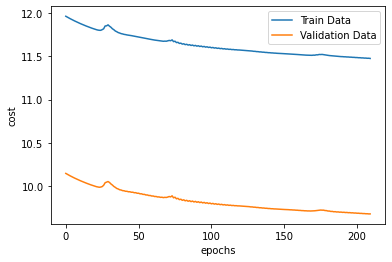

In [96]:
import matplotlib.pyplot as plt

plt.plot(cost_train[40:], label="Train Data")
plt.plot(cost_test[40:], label="Validation Data")
# print(np.max(current_percentage))
# plt.plot(current_percentage[:], label="Current Test")
plt.ylabel('cost')
plt.xlabel('epochs')
plt.legend()
plt.show()

## get correct percentage

In [97]:
m = len(X_test)
correct_m = 0
hatys, _ = L_model_forward(X_test, W, b)

for i in range(m):
    _y = np.argmax(hatys[i])
    if np.argmax(y_test[i]) == _y:
        correct_m += 1
        
print(correct_m / m)

0.9122


[[0.14132731 0.00164192 0.61161526 0.01667171 0.00106403 0.02143091
  0.20268054 0.0016398  0.0017826  0.00014592]]
2


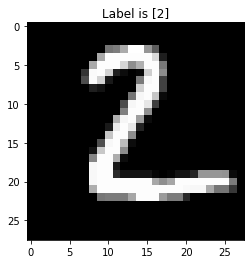

In [98]:
## Test
index = 1
single_label = np.where(y_test[index] == 1)[0]
single_Image = X_test[index].numpy()
single_Image_r = single_Image.reshape((28, 28))
test, _ = L_model_forward(single_Image, W, b)
print(test)
print(np.argmax(test))
plt.title('Label is {label}'.format(label=single_label))
plt.imshow(single_Image_r, cmap='gray')
plt.show()

In [99]:
test_data = pd.read_csv('test.csv')

In [100]:
hatys = []
for single_Image in test_data.values:
    haty, _ = L_model_forward(single_Image, W, b)
    hatys.append(np.argmax(haty))
    
hatys = pd.DataFrame(zip(range(1, len(hatys) + 1), hatys), columns=['ImageId', 'Label'])

<ipython-input-6-df679a0485eb>:2: RuntimeWarning: overflow encountered in exp
  return (np.exp(X)) / (np.sum(np.exp(X)))
<ipython-input-6-df679a0485eb>:2: RuntimeWarning: invalid value encountered in true_divide
  return (np.exp(X)) / (np.sum(np.exp(X)))


In [101]:
hatys.to_csv('submission.csv', index=False)